# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:

1.   добавьте лемматизацию в предобработку (любым способом)
2.   измените размер окна в большую или меньшую сторону
3.   измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [4]:
!pip install pymorphy3

In [5]:
import re

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from pymorphy3 import MorphAnalyzer

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

from tqdm.auto import tqdm
from pymystem3 import Mystem
mystem = Mystem()

In [4]:
wiki = open('/content/wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [6]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

1. Лемматизация через pymorphy3

In [7]:
def preprocess(text):
    morph = MorphAnalyzer()
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return tokens

In [7]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))

  0%|          | 0/20003 [00:00<?, ?it/s]

In [27]:
import pickle

with open('vocab.pkl', 'wb') as file:
    pickle.dump(vocab, file)

In [8]:
vocab.most_common(10)

[('в', 275172),
 ('и', 146585),
 ('год', 94984),
 ('на', 81230),
 ('—', 67491),
 ('с', 65101),
 ('быть', 58292),
 ('он', 38697),
 ('по', 36506),
 ('из', 26665)]

In [9]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

12460

In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
sentences = []

for text in tqdm(wiki):
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

  0%|          | 0/20003 [00:00<?, ?it/s]

In [26]:
with open('sentences.pkl', 'wb') as file:
    pickle.dump(sentences, file)

2. Изменение окна в большую сторону (в семинаре 5 в обоих функциях)

In [28]:
vocab_size = len(id2word)

In [31]:
# skip gram
def gen_batches_sg(sentences, window = 10, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [32]:
# # cbow
def gen_batches_cbow(sentences, window = 10, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

3. Изменила размер итогового вектора на 400

In [33]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=400)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=400)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_1 = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
model_1.fit(gen_batches_sg(sentences[:19000], window=10),
          validation_data=gen_batches_sg(sentences[19000:],  window=10),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.7797 - loss: 0.4682 - val_accuracy: 0.7897 - val_loss: 0.5171
Epoch 2/2
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8178 - loss: 0.4252 - val_accuracy: 0.8089 - val_loss: 0.4452


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


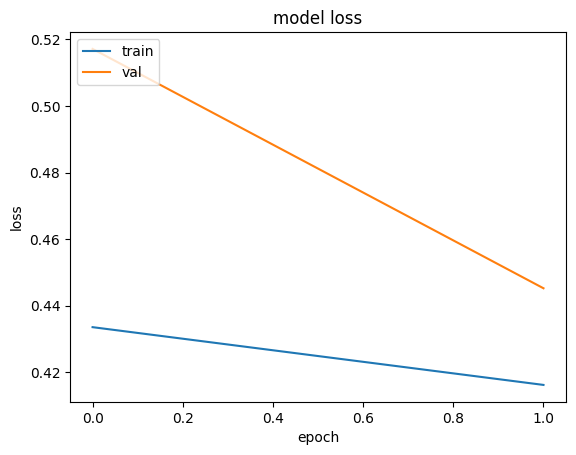

In [35]:
# summarize history for accuracy
print(model_1.history.history.keys())
plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
embeddings = model_1.layers[2].get_weights()[0]

In [37]:
embeddings[0]

array([ 1.83725394e-02, -1.17760301e-02,  4.94022481e-02,  3.23581584e-02,
        2.35780738e-02,  4.72458936e-02, -1.62068978e-02,  2.55681016e-02,
        1.23971812e-02, -8.06697458e-03, -2.31039170e-02, -3.31178084e-02,
        1.78657211e-02, -1.27253644e-02,  2.04409845e-02, -1.26268491e-02,
       -3.44113484e-02,  2.08068229e-02, -4.23140526e-02, -7.34139234e-04,
        4.77235205e-02,  3.89269739e-03,  3.81771214e-02,  1.89711899e-03,
       -2.06151009e-02,  6.15739822e-03, -1.78489089e-02,  9.04405117e-03,
        2.20448412e-02,  3.73672582e-02,  4.19352166e-02,  3.70254032e-02,
        2.21457519e-02,  3.28013413e-02,  4.99115027e-02,  4.95574623e-03,
        3.92613523e-02, -4.47985530e-02,  2.58260630e-02, -3.36287990e-02,
        4.62922715e-02, -4.71126549e-02,  2.37172730e-02,  2.18718387e-02,
       -3.76056880e-04, -1.40499249e-02, -2.60433201e-02, -3.58749852e-02,
       -2.90270206e-02, -5.07203490e-03,  9.82061028e-05,  4.85896729e-02,
        1.29437931e-02,  

In [38]:
most_similar('компьютер', embeddings)

['компьютер',
 'linux',
 'api',
 'движок',
 'аппаратный',
 'файл',
 'youtube',
 'программирование',
 'core',
 'графический']

In [39]:
most_similar('пучок', embeddings)

['пучок',
 'жёсткость',
 'полуось',
 'электромагнитный',
 'чашечка',
 'наружный',
 'бампер',
 'смещение',
 'заряд',
 'радиальный']

In [40]:
most_similar('кофе', embeddings)

['кофе',
 'грудной',
 'бутылка',
 'красноватый',
 'поворотный',
 'горшок',
 'ягода',
 'чашечка',
 'раствор',
 'колебание']

In [44]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=400)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=400)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_2 = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [45]:
model_2.fit(gen_batches_cbow(sentences[:20000], window=10),
          validation_data=gen_batches_cbow(sentences[20000:],  window=10),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.8219 - loss: 0.3990 - val_accuracy: 0.8433 - val_loss: 0.3610
Epoch 2/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8859 - loss: 0.2815 - val_accuracy: 0.8732 - val_loss: 0.3073


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


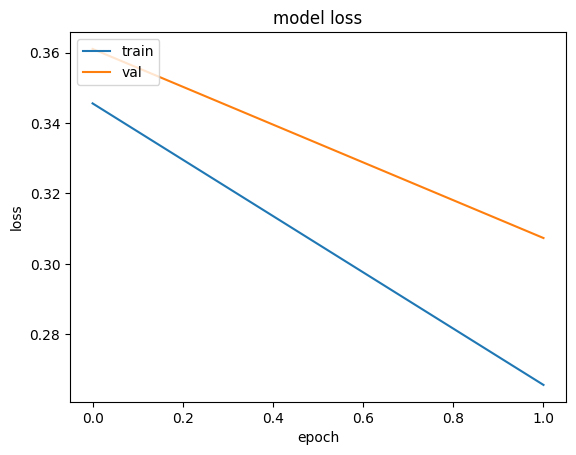

In [46]:
print(model_2.history.history.keys())
# summarize history for accuracy
plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
embeddings = model_2.layers[2].get_weights()[0]

In [49]:
most_similar('картофель', embeddings)

['картофель',
 'овощ',
 'зерновые',
 'пшеница',
 'табак',
 'кукуруза',
 'хлопок',
 'молоко',
 'вишня',
 'фрукт']

In [51]:
most_similar('медведь', embeddings)

['медведь',
 'олень',
 'ель',
 'берёза',
 'обезьяна',
 'млекопитающее',
 'бурый',
 'гнездиться',
 'волк',
 'крокодил']

In [52]:
most_similar('волк', embeddings) # а с волком смешные попались)))

['волк',
 'олень',
 'артемида',
 'bison',
 'черепаха',
 'зверь',
 '«любовь',
 'чудовище',
 'дракон',
 'огненный']

---------------

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [53]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 re

In [1]:
import gensim

In [2]:
wiki = open('wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [8]:
texts = [preprocess(text) for text in wiki]

In [10]:
import pickle
with open('texts.pkl', 'wb') as file:
    pickle.dump(texts, file)

In [13]:
w2v = gensim.models.Word2Vec(texts,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             vector_size=400,
                             min_count=5,
                             max_vocab_size=20000,
                             window=15,
                             epochs=10)

In [14]:
w2v.wv.most_similar('картофель')

[('выращивать', 0.8338526487350464),
 ('виноград', 0.8026772737503052),
 ('урожай', 0.8009599447250366),
 ('выращивание', 0.7948364615440369),
 ('зерно', 0.7945505380630493),
 ('животноводство', 0.7775506377220154),
 ('молочный', 0.7672120928764343),
 ('молоко', 0.7621452212333679),
 ('сорт', 0.7546305656433105),
 ('растительный', 0.7341501116752625)]

In [16]:
w2v.wv.most_similar('собака')

[('кошка', 0.6763800382614136),
 ('порода', 0.6278273463249207),
 ('пони', 0.6241822242736816),
 ('свердруп', 0.6034629940986633),
 ('охота', 0.6030621528625488),
 ('провиант', 0.5950902700424194),
 ('корм', 0.5790882110595703),
 ('полярник', 0.5790215134620667),
 ('спальный', 0.5771446824073792),
 ('пингвин', 0.5601394772529602)]

In [17]:
w2v.wv.most_similar('медведь')

[('зверь', 0.7739058136940002),
 ('дикий', 0.6960009336471558),
 ('охота', 0.6950730085372925),
 ('змея', 0.6677864789962769),
 ('кошка', 0.650214672088623),
 ('маша', 0.6390459537506104),
 ('охотник', 0.6253840923309326),
 ('маска', 0.598965585231781),
 ('птица', 0.5966999530792236),
 ('бык', 0.5966124534606934)]

In [22]:
ft = gensim.models.FastText(texts, min_n=4, max_n=10, window=10, epochs=10)

In [23]:
ft.wv.most_similar('картофель')

[('кукуруза', 0.812903106212616),
 ('вино', 0.7848080396652222),
 ('виноградник', 0.7816668152809143),
 ('овощ', 0.7713940143585205),
 ('виноделие', 0.7689164280891418),
 ('фрукт', 0.7632371187210083),
 ('медь', 0.7613620758056641),
 ('винья', 0.7552540302276611),
 ('вино»', 0.7537183165550232),
 ('зерно', 0.7520986795425415)]

In [24]:
ft.wv.most_similar('собака')

[('собака»', 0.9726831912994385),
 ('собак»', 0.9419456124305725),
 ('собачий', 0.8278874754905701),
 ('1/32', 0.8110237121582031),
 ('собака-пария', 0.8080062866210938),
 ('собачка', 0.7992647886276245),
 ('охота', 0.7527453899383545),
 ('«собачий', 0.725334107875824),
 ('кошка', 0.724402904510498),
 ('«рыба', 0.712129533290863)]

В препроцессинг надо в пунктуацию добавить «» видимо, но не буду перезагружать ноутбук, так как долго будет работать.

In [25]:
ft.wv.most_similar('медведь')

[('медведь»', 0.9220038652420044),
 ('«медведь»', 0.8485864400863647),
 ('медведя»', 0.8414791822433472),
 ('медвежий', 0.8321635723114014),
 ('медведица', 0.8203558325767517),
 ('«медвежий', 0.761189877986908),
 ('медведка', 0.7541730403900146),
 ('птица', 0.7186551690101624),
 ('«собачий', 0.6966859102249146),
 ('чеснок', 0.6960702538490295)]

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

см. отдельную тетрадку